In [1]:
import numpy as np
import os
import pandas as pd
import scipy
'''
Below is the needed functionality for the track reconstruction evaluation
'''

def read_track_txt(track_dir):
    raw_tracks = []
    with open(track_dir, 'r') as file:
        for track in file:
            track = list(map(int, track.split()))
            raw_tracks.append(track)

    return raw_tracks

def get_tracks(track_dir, min_num_hits):
    '''
    Input: List of track candidates
    Output: List of tracks with at least min_num_hits hits
    '''
    raw_tracks = read_track_txt(track_dir)
    track_candidates = [track for track in raw_tracks if len(track) >= min_num_hits]

    return track_candidates

def get_hit_particle_ids(hit_list, map):
    '''
    Input: List of hits
    Output: List of particle ids for each hit
    '''
    hit_particle_ids = []

    for hit in hit_list:
        hit_particle_ids.append(map[hit]**2)

    return hit_particle_ids

def create_hit_particle_dict(particles_dir, truth_dir):
    '''
    Input: Directories to the particles and truth csv files
    Output: Dictionary with hit_id as keys and particle_type as values
    '''
    particles_df = pd.read_csv(particles_dir)
    truth_df = pd.read_csv(truth_dir)

    # Merge the dataframes on particle_id
    merged_df = pd.merge(truth_df[['hit_id', 'particle_id']], particles_df[['particle_id', 'particle_type']], on='particle_id')

    # Create the dictionary with hit_id as keys and particle_type as values
    hit_particle_dict = dict(zip(merged_df['hit_id'], merged_df['particle_type']))

    return hit_particle_dict

def clopper_pearson(passed: float, total: float, level: float = 0.68):
    """
    Estimate the confidence interval for a sampled binomial random variable with Clopper-Pearson.
    `passed` = number of successes; `total` = number trials; `level` = the confidence level.
    The function returns a `(low, high)` pair of numbers indicating the lower and upper error bars.
    """
    alpha = (1 - level) / 2
    lo = scipy.stats.beta.ppf(alpha, passed, total - passed + 1) if passed > 0 else 0.0
    hi = (
        scipy.stats.beta.ppf(1 - alpha, passed + 1, total - passed)
        if passed < total
        else 1.0
    )
    average = passed / total if total != 0 else 0.0
    return (average - lo, hi - average)

def count_true_fake_tracks(dir, feature_store, min_track_length=4, samplesize=100000):
    '''
    This is the centerpiece for the track reconstruction evaluation!

    Input:  Directory to the track txt files, feature store
            min. track length default: 4, samplesize default: all events in dir
    Output: Fake/reconstruction ratio with clopper pearson errors, raw numbers for fake/true/total tracks
    '''

    #Set counters
    num_true = 0
    num_fake = 0
    num_evts = 0
    num_of_tracks = []
    err_reco = np.array([0,0])
    err_fake = np.array([0,0])

    fake_ratio = 0
    reco_ratio = 0
    
    for set in ['testset']: #initially did this for train and valset as well but this is only allowed if the data has not been used in training
        tracks_dir = dir + f'/{set}_tracks' #directory within testset, containing the track txt files
        num_evts += len(os.listdir(tracks_dir)) #count the number of events
        for track_txt in os.listdir(tracks_dir): #look at single track txt file -> can contain multiple track candidates
            if num_evts > samplesize: #break if samplesize is reached
                break

            track_path = os.path.join(tracks_dir, track_txt) #compose path to track txt file

            track_candidates = get_tracks(track_path, min_track_length) #filter track candidates with at least min_track_length hits
            num_of_tracks.append(len(track_candidates)) #count number of track candidates

            if len(track_candidates) == 0: #if there are no track candidates, continue
                continue
            
            #read corresponding truth and particle csv files
            truth_path = '/mnt/data1/karres/cosmics_test'+f'/{feature_store}'+f'/{set}'f'/{track_txt[:-4]}-truth.csv'
            particle_path = '/mnt/data1/karres/cosmics_test'+f'/{feature_store}'+f'/{set}'f'/{track_txt[:-4]}-particles.csv'

            #create particle id map for this event as explained above
            particle_id_map = create_hit_particle_dict(particle_path, truth_path)
            true_per_event = 0

            for track in track_candidates: #loop over all correct track candidates
                hit_particle_ids = get_hit_particle_ids(track, particle_id_map) #get particle ids for each hit in the track candidate
                if all(x == 13**2 for x in hit_particle_ids):
                    true_per_event += 1 #count track as true if all hits are muons (+-13) -> considers muons and anti muons as the same particle though -> should be changed perhaps

            if true_per_event >= 1:
                num_true += 1 #essentially count true triggers
            else:
                num_fake += 1 #count fake triggers

    reco_ratio = num_true/num_evts #really only makes sense for cosmics only and cosmics w/ michel
    fake_ratio = num_fake/num_evts
    
    err_reco = np.array(clopper_pearson(num_true, num_evts))
    err_fake = np.array(clopper_pearson(num_fake, num_evts))
    
    return fake_ratio, reco_ratio, num_of_tracks, num_true, num_fake, err_reco[0], err_reco[1], err_fake[0], err_fake[1]

In [ ]:
import pandas as pd
import os

stage_dir = '/mnt/data1/karres/cosmics_test/thesis_results/cosmics_with_michel/' #containing folders to different gnn models
my_stage_dir = '/mnt/data1/tkar/cosmic_new/gnn/cosmic_michel_f3/aa/cm_m_mixed_gnn/connected_components/'
feature_store = 'feature_store_cosmic_michel' #name of the feature store the gnn was infered on (fully connected graphs)

loc_dir = '/mnt/data1/tkar/cosmic_new/results/track_level/cosmics_with_michel_new/'

#gnns = ['c_only', 'cm', 'cm_c', 'cm_m','cm_m_c'] #gnns for cosmics only -> cm_m did not work, therefore trained another gnn on cosmics only as well
gnns = ['cm', 'cm_c', 'cm_m','cm_m_c'] #gnns for all other cases

for gnn in gnns:
    fake_ratios_3 = []
    reco_ratios_3 = []
    num_of_tracks_3 = []
    num_true_3 = []
    num_fake_3 = []
    err_reco_3_down = []
    err_reco_3_up = []
    err_fake_3_down = []
    err_fake_3_up = []

    fake_ratios_4 = []
    reco_ratios_4 = []
    num_of_tracks_4 = []
    num_true_4 = []
    num_fake_4 = []
    err_reco_4_down = []
    err_reco_4_up = []
    err_fake_4_down = []
    err_fake_4_up = []

    dir = stage_dir+gnn+'_gnn/connected_components/' #compose path to connected components folder of specific gnn infered on specific data
    #if gnn == 'cm_m':
    #    dir = my_stage_dir

    
    #connected components folder contains subfolders called 50, 60,...,90, 925, 950,...; meaning 0.5, 0.6, 0.9, 0.925, 0.950,...
    score_cuts = [int(cut)/100 if int(cut)<100 else int(cut)/1000 for cut in sorted(os.listdir(dir)) if os.path.isdir(os.path.join(dir, cut))] #get list of score cuts found in that folder
    size = 100000 #sample size

    dir_list = [cut for cut in sorted(os.listdir(dir)) if os.path.isdir(os.path.join(dir, cut))] #get all subfolders in connected components folder
    print(dir_list)
    print(dir+cut)
    for cut in dir_list: #get track recon metrics for min track length 3 for every score cut individually
        new_fake, new_reco, new_num, new_num_true, new_num_fake, new_err_reco_down, new_err_reco_up, new_err_fake_down, new_err_fake_up = count_true_fake_tracks(dir+cut, feature_store, 3, size)
        fake_ratios_3.append(new_fake)
        reco_ratios_3.append(new_reco)
        num_of_tracks_3.append(new_num)
        num_true_3.append(new_num_true)
        num_fake_3.append(new_num_fake)
        err_reco_3_down.append(new_err_reco_down)
        err_reco_3_up.append(new_err_reco_up)
        err_fake_3_down.append(new_err_fake_down)
        err_fake_3_up.append(new_err_fake_up)

    for cut in dir_list: #same for track length 4
        new_fake, new_reco, new_num, new_num_true, new_num_fake, new_err_reco_down, new_err_reco_up, new_err_fake_down, new_err_fake_up = count_true_fake_tracks(dir+cut, feature_store, 4, size)
        fake_ratios_4.append(new_fake)
        reco_ratios_4.append(new_reco)
        num_of_tracks_4.append(new_num)
        num_true_4.append(new_num_true)
        num_fake_4.append(new_num_fake)
        err_reco_4_down.append(new_err_reco_down)
        err_reco_4_up.append(new_err_reco_up)
        err_fake_4_down.append(new_err_fake_down)
        err_fake_4_up.append(new_err_fake_up)

    #put all data in a dictionary and save it as a csv file
    data_to_save = {'fr_3':fake_ratios_3, 'rr_3': reco_ratios_3, 'num_true_3': num_true_3, 'num_fake_3': num_fake_3, 'err_reco_3_down': err_reco_3_down, 'err_reco_3_up': err_reco_3_up, 'err_fake_3_down': err_fake_3_down, 'err_fake_3_up': err_fake_3_up,
                'fr_4': fake_ratios_4, 'rr_4': reco_ratios_4, 'num_true_4': num_true_4, 'num_fake_4': num_fake_4, 'err_reco_4_down': err_reco_4_down, 'err_reco_4_up': err_reco_4_up, 'err_fake_4_down': err_fake_4_down, 'err_fake_4_up': err_fake_4_up}

    (pd.DataFrame.from_dict(data=data_to_save, orient='index').to_csv(loc_dir+'fake_rate_data_testset_only.csv', header=False))

['50', '55', '60', '65', '70', '75', '80', '85', '90', '925', '950', '975', '980', '985', '990', '995', '999']
/mnt/data1/karres/cosmics_test/thesis_results/cosmics_with_michel/cm_gnn/connected_components/999
['50', '55', '60', '65', '70', '75', '80', '85', '90', '925', '950', '975', '980', '985', '990', '995', '999']
/mnt/data1/karres/cosmics_test/thesis_results/cosmics_with_michel/cm_c_gnn/connected_components/999
['50', '55', '60', '65', '70', '75', '80', '85', '90', '925', '950', '975', '980', '985', '990', '995', '999']
/mnt/data1/tkar/cosmic_new/gnn/cosmic_michel_f3/aa/cm_m_mixed_gnn/connected_components/999


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data1/karres/cosmics_test/feature_store_cosmic_michel/testset/event000001534-particles.csv'

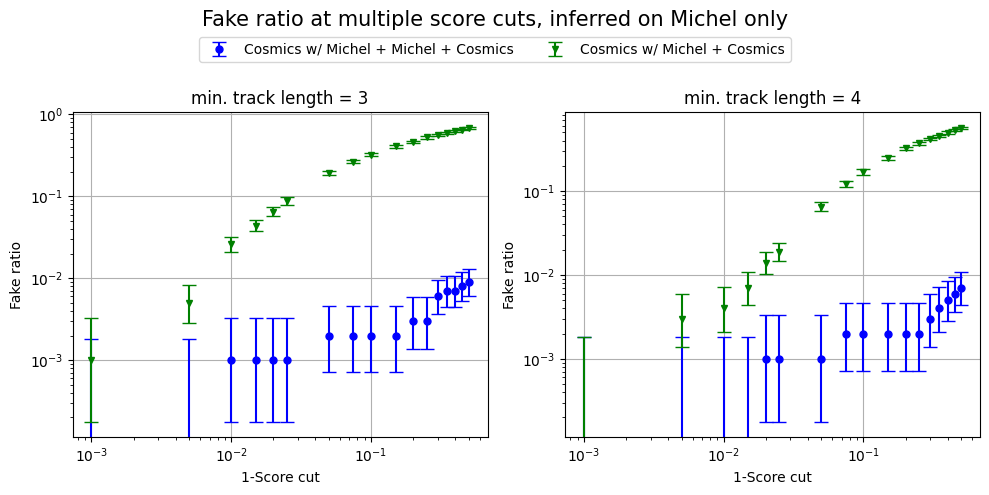

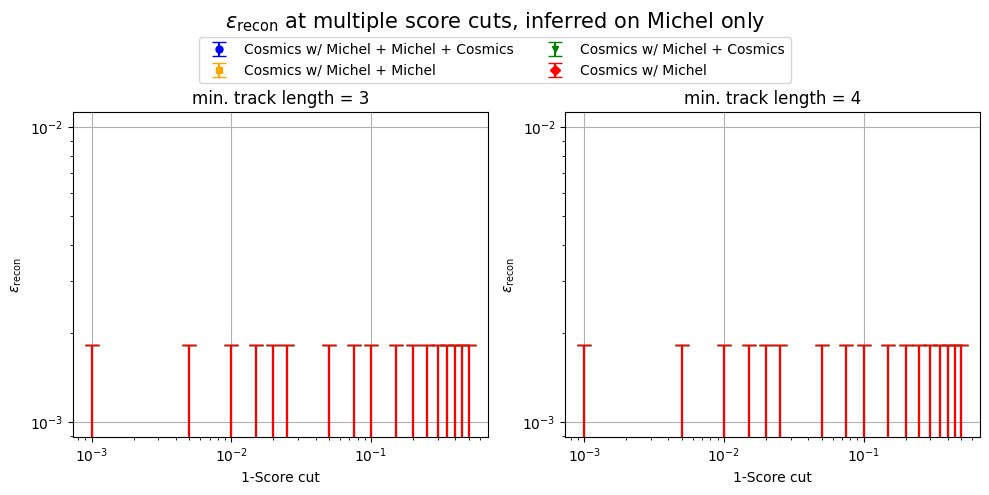

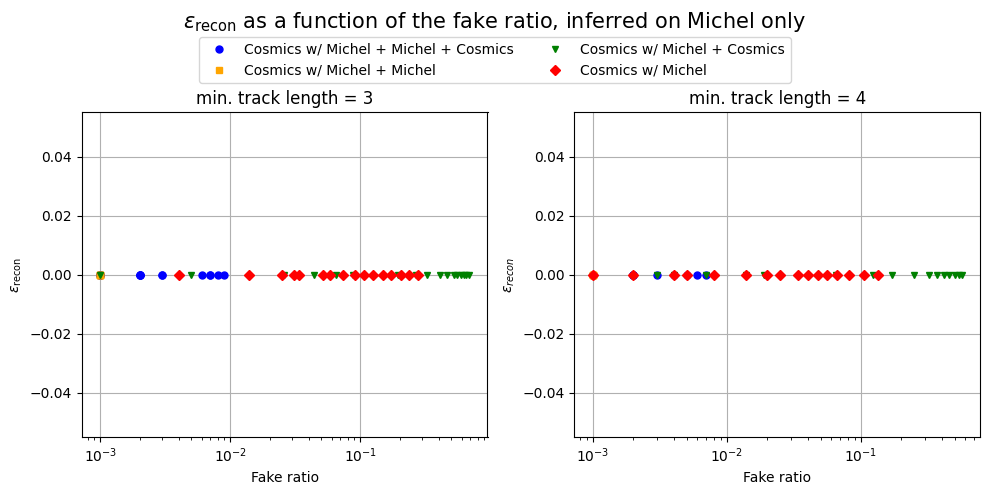

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plot_dir = '/mnt/data1/tkar/cosmic_new/results/track_level/' #dir to save plots

cosmics_dir = '/mnt/data1/karres/cosmics_test/thesis_results/cosmics_only/' #cosmics only dir (contains "fake_rate_data_testset_only.csv" inside of connected components folder)
michel_dir = '/mnt/data1/karres/cosmics_test/thesis_results/michel_only/'
cosmic_michel_dir = '/mnt/data1/karres/cosmics_test/thesis_results/cosmics_with_michel/'

score_cuts = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975, 0.98, 0.985, 0.99, 0.995, 0.999]

sample = 'Michel only' #appears in figure title
filename = 'michel_only_large' #file name
directory = michel_dir  #directory to the scored graphs

gnns = ['cm_m_c_gnn','cm_m_gnn', 'cm_c_gnn', 'cm_gnn'] #folder names of the gnns within the chosen directory
gnn_names = ['Cosmics w/ Michel + Michel + Cosmics', 'Cosmics w/ Michel + Michel', 'Cosmics w/ Michel + Cosmics', 'Cosmics w/ Michel'] #names of the gnns for the legend
gnn_colours =  ['blue','orange', 'green', 'red']
gnn_markers = ['o', 's', 'v', 'D']

######################################################################################################
#Fake vs Score

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.grid(True)
ax2.grid(True)

ax1.set_title('min. track length = 3')
ax1.set_xlabel('1-Score cut')
ax1.set_ylabel('Fake ratio') #This is the acceptance if plotting michel only

ax2.set_title('min. track length = 4')
ax2.set_xlabel('1-Score cut')
ax2.set_ylabel('Fake ratio')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
#might need to set some limits for the axes for coherence

for index, (gnn, gnn_name, colour, m) in enumerate(zip(gnns, gnn_names, gnn_colours, gnn_markers)): #read in eval data for every gnn individually
    if index == 1 or index == 3: #skip gnns if not needed in plot
        continue

    path = directory + gnn + '/connected_components/fake_rate_data_testset_only.csv' 
    data = pd.read_csv(path, header=None, index_col=0)
    data = data.apply(lambda row: row.tolist(), axis=1).to_dict() #convert to dictionary
    
    fr_3_err = np.array([data['err_fake_3_down'], data['err_fake_3_up']]) #fake ratio errors
    fr_4_err = np.array([data['err_fake_4_down'], data['err_fake_4_up']])

    ax1.errorbar(1-np.array(score_cuts), data['fr_3'], yerr = fr_3_err, marker=m, 
                 label=gnn_name, color=colour, capsize=5, linestyle='None', markersize=5)
    ax2.errorbar(1-np.array(score_cuts), data['fr_4'], yerr = fr_4_err, marker=m, 
                 label=gnn_name, color=colour, capsize=5, linestyle='None', markersize=5)

line, label = ax1.get_legend_handles_labels()
fig.legend(line, label, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.94)) #place legend on top of the plot
plt.tight_layout(rect=[0, 0, 1, 0.85])
fig.suptitle(f"Fake ratio at multiple score cuts, inferred on {sample}", fontsize=15)
fig.savefig(plot_dir + f"fake_vs_score_{filename}.pdf", format='pdf')
plt.show()

######################################################################################################
#Reco vs Score
#same spiel for reconstruction ratio vs score cut and then reconstruction ratio vs fake ratio afterwards

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.grid(True)
ax2.grid(True)

ax1.set_title('min. track length = 3')
ax1.set_xlabel('1-Score cut')
ax1.set_ylabel(r'$\epsilon_\text{recon}$')

ax2.set_title('min. track length = 4')
ax2.set_xlabel('1-Score cut')
ax2.set_ylabel(r'$\epsilon_\text{recon}$')

ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

for index, (gnn, gnn_name, colour, m) in enumerate(zip(gnns, gnn_names, gnn_colours, gnn_markers)):
    if index == 10 or index == 30:
        continue

    path = directory + gnn + '/connected_components/fake_rate_data_testset_only.csv'
    data = pd.read_csv(path, header=None, index_col=0)
    data = data.apply(lambda row: row.tolist(), axis=1).to_dict()

    rr_3_err = np.array([data['err_reco_3_down'], data['err_reco_3_up']])
    rr_4_err = np.array([data['err_reco_4_down'], data['err_reco_4_up']])

    ax1.errorbar(1-np.array(score_cuts), data['rr_3'], yerr = rr_3_err, marker=m, 
                 label=gnn_name, color=colour, capsize=5, linestyle='None', markersize=5)
    ax2.errorbar(1-np.array(score_cuts), data['rr_4'], yerr = rr_4_err, marker=m, 
                 label=gnn_name, color=colour, capsize=5, linestyle='None', markersize=5)

    #ax1.plot(score_cuts[6:], data['rr_3'][6:], marker=marker, label=gnn_name, color=colour)
    #ax2.plot(score_cuts[6:], data['rr_4'][6:], marker=marker, label=gnn_name, color=colour)  

line, label = ax1.get_legend_handles_labels()
fig.legend(line, label, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.94))
plt.tight_layout(rect=[0, 0, 1, 0.85])
fig.suptitle(r'$\epsilon_\text{recon}$'+ f" at multiple score cuts, inferred on {sample}", fontsize=15)
fig.savefig(plot_dir + f"reco_vs_score_{filename}.pdf", format='pdf')
plt.show()

###################################################################################################
#Reco vs Fake

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.grid(True)
ax2.grid(True)

ax1.set_title('min. track length = 3')
ax1.set_xlabel('Fake ratio')
ax1.set_ylabel(r'$\epsilon_\text{recon}$')
ax1.set_xscale('log')

ax2.set_title('min. track length = 4')
ax2.set_xlabel('Fake ratio')
ax2.set_ylabel(r'$\epsilon_{recon}$')
ax2.set_xscale('log')

for index, (gnn, gnn_name, colour, m) in enumerate(zip(gnns, gnn_names, gnn_colours, gnn_markers)):
    if index == 10 or index == 30:
        continue

    path = directory + gnn + '/connected_components/fake_rate_data_testset_only.csv'
    data = pd.read_csv(path, header=None, index_col=0)
    data = data.apply(lambda row: row.tolist(), axis=1).to_dict()

    ax1.plot(data['fr_3'], np.array(data['rr_3']), marker=m, label=gnn_name, color=colour, markersize=5, linestyle='None')
    ax2.plot(data['fr_4'], np.array(data['rr_4']), marker=m, label=gnn_name, color=colour, markersize=5, linestyle='None')  

line, label = ax1.get_legend_handles_labels()
fig.legend(line, label, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.94))
plt.tight_layout(rect=[0, 0, 1, 0.85])
fig.suptitle(r"$\epsilon_\text{recon}$" + f" as a function of the fake ratio, inferred on {sample}", fontsize=15)
fig.savefig(plot_dir + f"reco_vs_fake_{filename}.pdf", format='pdf')